## Подключение гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install navec

## Импортирование библиотек

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras import utils, models

from keras.callbacks import ModelCheckpoint

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import pandas as pd

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import re

from navec import Navec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
max_comment_len = 12
vector_size = 300

## Загрузка данных для обучения и тестирования

In [ ]:
file = open('/content/drive/MyDrive/bc/x_train', 'rb')
x_train = np.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/bc/y_train', 'rb')
y_train = np.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/bc/x_test', 'rb')
x_test = np.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/bc/y_test', 'rb')
y_test = np.load(file)
file.close()

In [ ]:
x_train = x_train[:, None, :]

In [ ]:
x_test = x_test[:, None, :]

In [ ]:
x_train[0].shape

## Создание нейронной сети


In [ ]:
model = Sequential()
model.add(Input(shape=(1, max_comment_len * vector_size)))
model.add(Bidirectional(LSTM(8,
                        return_sequences=True,
                        dropout=0.8,
                        recurrent_dropout=0.8)))
model.add(Bidirectional(LSTM(16,
                        return_sequences=True,
                        dropout=0.8,
                        recurrent_dropout=0.8)))
model.add(Bidirectional(LSTM(4,
                        return_sequences=False,
                        dropout=0.8,
                        recurrent_dropout=0.8)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

## Если необходимо, загрузка сохранённой модели с гугл диска

In [ ]:
model = models.load_model('/content/drive/MyDrive/bc/BiLSTM_light')

## Обучаем нейронную сеть

Callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Модель сохраняется в папке на гугл диске.

In [ ]:
model_save_path = '/content/drive/MyDrive/bc/BiLSTM'
checkpoint_callback1 = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback1])

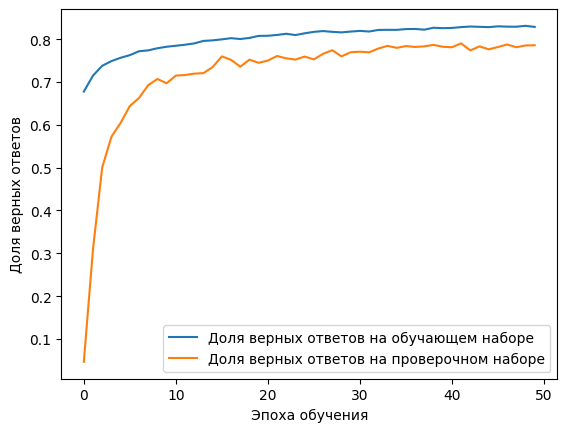

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig(fname='training.png')
plt.show()

In [ ]:
max(history.history['val_accuracy'])

0.7900462746620178

## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
quality = model.evaluate(x_test, y_test, verbose=0)
print(f'Нейросеть правильно определила эмоциональную окраску {quality[1]:.2%} комментариев')

Нейросеть правильно определила эмоциональную окраску 90.60% комментариев


## Оцениваем тональность на собственном комментарие

In [ ]:
navec = Navec.load('/content/drive/MyDrive/bc/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
russian_stopwords = stopwords.words("russian")

In [ ]:
important_words = ['не', 'и', 'или', 'но']

In [ ]:
for word in important_words:
  if word in russian_stopwords:
    russian_stopwords.remove(word)

In [ ]:
def clear_text(text: str) -> str:
  cleared_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
  return ' '.join(cleared_text.split())

def tokenize(text: str) -> list:
  tokens = text.split()
  passed_tokens = []
  for token in tokens:
    if not(token in russian_stopwords):
      passed_tokens.append(token)
  return passed_tokens

In [ ]:
def vectorize_tokens(tokens, navec, max_len):
    unk = navec['<unk>']
    text_embeddings = []
    for tocken in tokens:
        embedding = navec.get(tocken, unk)
        text_embeddings.append(embedding)
    l = len(text_embeddings)
    if l > max_len:
        text_embeddings = text_embeddings[:max_len]
    else:
        text_embeddings = [navec['<pad>']] * (max_len - l) + text_embeddings
    return text_embeddings

In [ ]:
text = 'Вы не правы. Это просто возмутительно! Только такой ужасный человек, как вы, способны сказать такое!'

In [ ]:
tokens = tokenize(clear_text(text))

In [ ]:
tokens

['не',
 'правы',
 'это',
 'просто',
 'возмутительно',
 'ужасный',
 'человек',
 'способны',
 'сказать',
 'такое']

In [ ]:
vectors = vectorize_tokens(tokens, navec, max_comment_len)

In [ ]:
vectors = np.array([vectors])

In [ ]:
vectors.shape

(1, 12, 300)

In [ ]:
vectors = vectors.reshape(1, max_comment_len * vector_size)

In [ ]:
vectors = vectors[:, None, :]

In [ ]:
result = model.predict(vectors)

1/1 [==============================] - 2s 2s/step


In [ ]:
result

array([[0.07464638]], dtype=float32)